## Libraries

In [1]:
import rawpy as rw
import numpy as  np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Reading the raw image

In [35]:
with rw.imread('Images/scene_raw.CR2.dng') as raw:
    raw_image = raw.raw_image.copy()
    raw_colors = raw.raw_colors.copy()
    color_desc = raw.color_desc
    white_level_per_channel = raw.camera_white_level_per_channel
    black_level_per_channel = raw.black_level_per_channel
    size = raw.sizes
    image = raw.postprocess()

## Extract the channels from Bayes matrix

In [6]:
color_desc

b'RGBG'

In [7]:
white_level

[4000, 4000, 4000, 15120]

In [8]:
black_level

[255, 255, 255, 255]

In [11]:
def generate_matrix_channels(shape, n_channels):
    
    bayes = np.zeros(shape)
    
    channel_dimension = np.zeros_like(n_channels)
    
    matrix_channels = bayes[:,:,np.newaxis] + channel_dimension[np.newaxis,np.newaxis,:]
    
    return matrix_channels

def extract_channels(raw_image, raw_colors):
    
    n_channels = np.unique(raw_colors)
    
    image_channels = generate_matrix_channels(shape = raw_image.shape, n_channels = n_channels)
    
    for channel in n_channels:
        mask = raw_colors != channel
        image_channels[:,:,channel] = raw_image.copy()
        image_channels[:,:,channel][mask] = 0
        
    return image_channels

In [12]:
image_channels = extract_channels(raw_image, raw_colors)

## Histograms

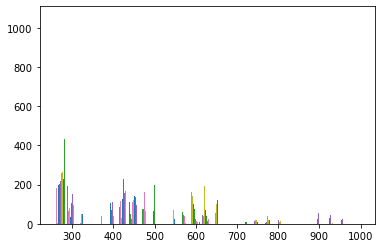

In [79]:
plt.hist(image_channels[:,:,0], bins = 25, range = (255, 1000));

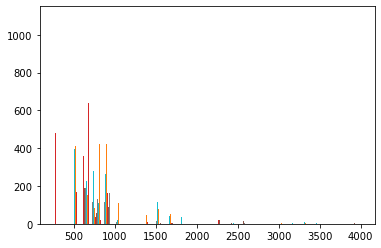

In [80]:
plt.hist(image_channels[:,:,1], bins = 25, range = (255, 4000));

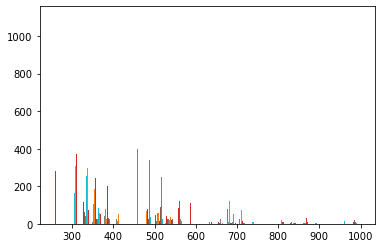

In [81]:
plt.hist(image_channels[:,:,2], bins = 25, range = (255, 1000));

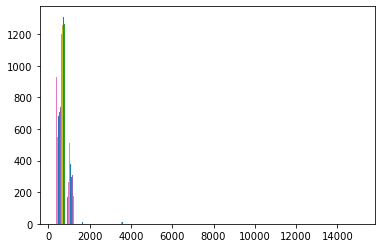

In [82]:
plt.hist(image_channels[:,:,3], bins = 25, range = (255, 15120));

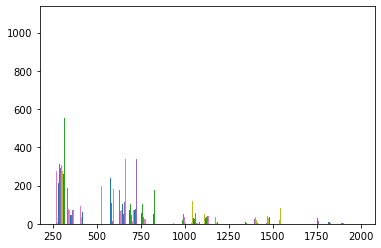

In [83]:
plt.hist(image_channels[:,:,3], bins = 25, range = (255, 2000));

## Plotting images

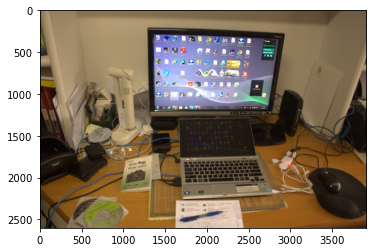

In [84]:
plt.imshow(image);

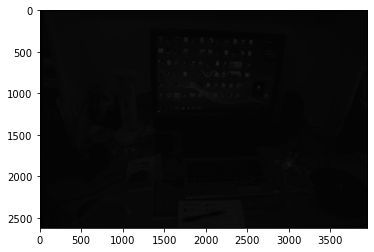

In [91]:
plt.imshow(image_channels[:,:,0], cmap = 'gray');

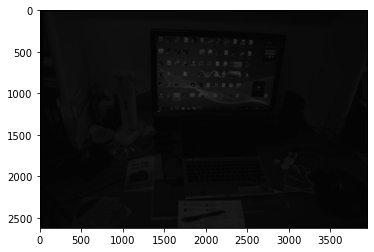

In [92]:
plt.imshow(image_channels[:,:,1], cmap = 'gray');

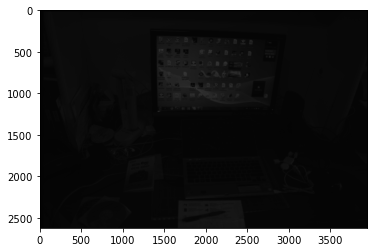

In [93]:
plt.imshow(image_channels[:,:,2], cmap = 'gray');

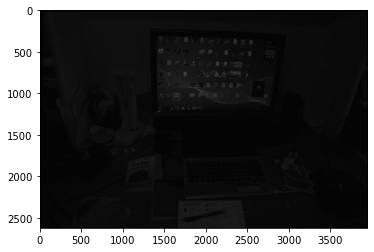

In [94]:
plt.imshow(image_channels[:,:,3], cmap = 'gray');

## Linearization

In [43]:
f = lambda x, minimum, maximum: (255*(x-minimum)/(maximum-minimum)).astype(int)

def linearization(image, n_channels, white_level_per_channel, black_level_per_channel):
    
    image_linearized = np.zeros_like(image)
    
    for n_channel, white_level, black_level in zip(n_channels, white_level_per_channel, black_level_per_channel):
        
        g = lambda x: f(x = x, minimum = white_level, maximum = black_level)
        
        image_linearized[:,:,n_channel] = g(image[:,:,n_channel])
        
        mask = image[:,:,n_channel] < minimum
        
        image_linearized[:,:,n_channel][mask] = 0
        
        mask = image[:,:,n_channel] > maximum
        
        image_linearized[:,:,n_channel][mask] = 255
        
    return image_linearized

In [44]:
image_linearized = linearization(image = image_channels, 
                                 n_channels = np.unique(raw_colors), 
                                 white_level_per_channel = white_level_per_channel, 
                                 black_level_per_channel = black_level_per_channel)

## Convert to RGB

In [76]:
image_rgb = generate_matrix_channels(shape = raw_image.shape, n_channels = range(3))
image_rgb[:,:,:] = image_linearized[:,:,:3]
image_rgb[:,:,1] = image_rgb[:,:,1] + image_linearized[:,:,3]
image_rgb = image_rgb.astype(int)

## Histograms after linearization

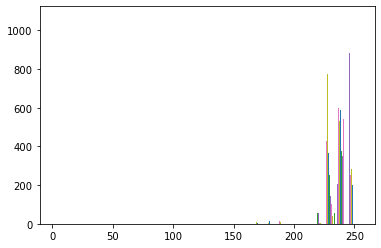

In [52]:
plt.hist(image_rgb[:,:,0], bins = 25, range = (1,255));

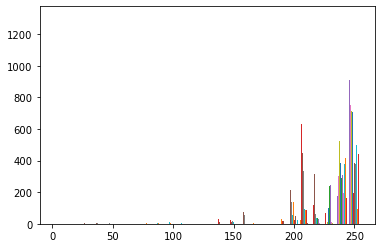

In [53]:
plt.hist(image_rgb[:,:,1], bins = 25, range = (1,255));

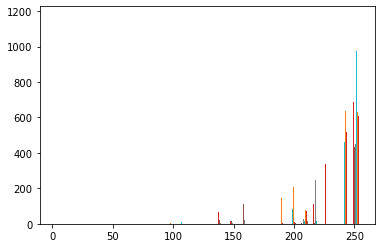

In [54]:
plt.hist(image_rgb[:,:,2], bins = 25, range = (1,255));

## Plotting images after linearization

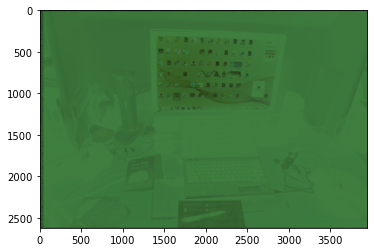

In [87]:
plt.imshow(image_rgb); ### Full image

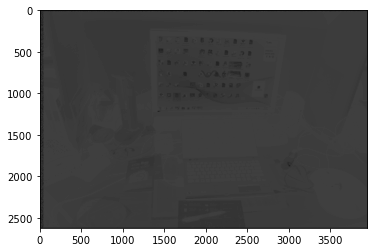

In [77]:
plt.imshow(image_rgb[:,:,0], cmap = 'gray'); ### Red

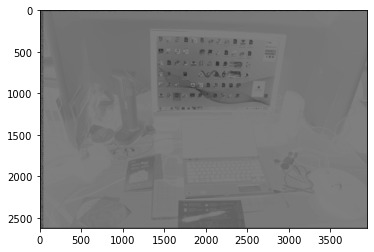

In [78]:
plt.imshow(image_rgb[:,:,1], cmap = 'gray'); ### Green

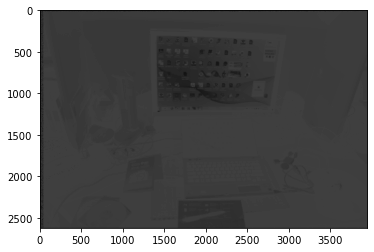

In [79]:
plt.imshow(image_rgb[:,:,2], cmap = 'gray'); ### Blue

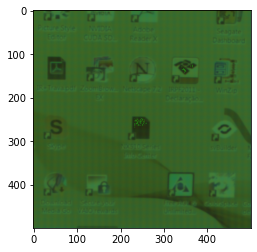

In [84]:
plt.imshow(image_rgb[500:1000,1500:2000,:]); ### Full image

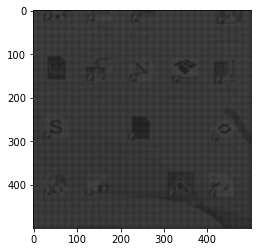

In [80]:
plt.imshow(image_rgb[500:1000,1500:2000,0], cmap = 'gray'); ### Red

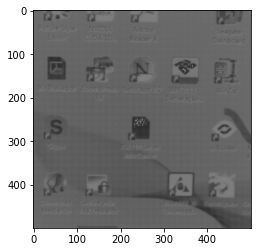

In [81]:
plt.imshow(image_rgb[500:1000,1500:2000,1], cmap = 'gray'); ### Green

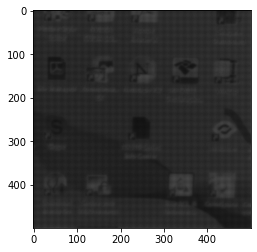

In [82]:
plt.imshow(image_rgb[500:1000,1500:2000,2], cmap = 'gray'); ### Blue

## Demosaicking

In [88]:
from scipy import interpolate

In [90]:
mask = raw_colors == 0

In [101]:
image_rgb[:,:,0][mask].reshape((np.sum(mask[:,0]),np.sum(mask[0,:])))

array([[255, 255, 255, ...,   9,   9,   9],
       [255,   0,   0, ..., 254, 254, 253],
       [  0, 254, 254, ..., 255,   0, 254],
       ...,
       [254, 254, 254, ..., 252, 252, 252],
       [  0, 254,   0, ..., 252, 252, 251],
       [  0,   0,   0, ...,   0,   0,   0]])

In [94]:
mask.shape

(2622, 3948)

In [96]:
2587914/(2622*3948)

0.25

In [98]:
np.sum(mask[0,:])

1974

In [99]:
np.sum(mask[:,0])

1311

In [100]:
np.sum(mask[:,0])*np.sum(mask[0,:])

2587914